**Grad-CAM plot**

In [71]:
import sys
import torch
import pickle
import numpy as np
sys.path.insert(0, "../../src")
from models import CNNModel
import matplotlib.pyplot as plt
from datasets import MVTSDataset
import matplotlib.colors as mcolors
from captum.attr import GuidedGradCam
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.size'] = 8

In [72]:
def plot_attributions(mvts, attribution_mask, max_val=None, name=None):

    dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
            'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
            'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
            'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

    mvts = mvts.T
    attribution_mask = attribution_mask.T

    mvts[mvts==0] = np.nan
    mvts = unity_based_normalization(mvts) # normalize the data so easier to see each feature in the original data

    n_void = np.isnan(mvts[0]).sum()

    fig = plt.figure(figsize=(6, 25))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.3)
    with open('/Users/brandonlpanos/custom_cmap.pkl', 'rb') as f: custom_cmap = pickle.load(f)

    # plot input mvt
    ax1 = fig.add_subplot(gs[0:1, :])
    ax1.set_title(f'mvts')
    ax1.set_ylabel('Features')
    ax1.set_xlabel('Time (min) before flare start')
    im1 = ax1.imshow(mvts, aspect='auto', cmap='gray', interpolation='spline16', vmin=0, vmax=np.nanmax(mvts), extent=[180, 0, 35, 0], alpha=0.5)
    ax1.yaxis.grid(True, "major")
    ax1.xaxis.grid(True, "major")
    ax1.xaxis.set_major_locator(MultipleLocator(20))
    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.tick_params(which='major', length=5,width=1)
    ax1.tick_params(which='minor', length=3,width=1)
    # Plot vertical line at max value of attribution mask
    ax1.axvline(x=max_val, color='w', linestyle='--', linewidth=1)
    cbar1 = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
    cbar1.set_label('Intensity')
    cbar1.ax.set_yticks([]) 

    # Plot saliency map
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('saliency map')
    ax2.set_ylabel('Features')
    ax2.set_xlabel('Time (min) before flare start')
    attribution_mask[:,0:n_void] = np.nan
    im2 = ax2.imshow(attribution_mask, aspect='auto', cmap=custom_cmap, interpolation='spline16', extent=[180, 0, 35, 0], alpha=1)
    ax2.yaxis.grid(True, "major")
    ax2.xaxis.grid(True, "major")
    ax2.xaxis.set_major_locator(MultipleLocator(20))
    ax2.xaxis.set_minor_locator(MultipleLocator(10))
    ax2.yaxis.set_major_locator(MultipleLocator(5))
    ax2.yaxis.set_minor_locator(MultipleLocator(1))
    ax2.tick_params(which='major', length=5,width=1)
    ax2.tick_params(which='minor', length=3,width=1)
    # Plot vertical line at max value of attribution mask
    ax2.axvline(x=max_val, color='w', linestyle='--', linewidth=1)
    cbar2 = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
    cbar2.set_label('Intensity')
    cbar2.ax.set_yticks([]) 

    # Plot the light curves
    gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
    ax3 = fig.add_subplot(gs2[:, :])
    ax3.set_title('features (light curves)')
    for i in range(6):
        for j in range(6):
            ind = (i * 6) + j
            if ind < len(dtypes):  # Check if index is within the range of dtypes
                ax = fig.add_subplot(gs2[i, j])
                # Plot vertical line at max value of attribution mask
                ax.axvline(x=max_val, color='k', linestyle='--', linewidth=0.5)
                # Handle NaN values in attribution_mask
                masked_mask = np.ma.masked_invalid(attribution_mask)
                # Normalize the masked_mask to range [0, 1]
                norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
                normalized_mask = norm(masked_mask)
                # Convert the normalized mask to RGB
                cmap = custom_cmap
                rgb_colors = cmap(normalized_mask)
                light_curve = mvts[ind]
                light_curve_colors = rgb_colors[ind, :, :]
                for k, clr in enumerate(light_curve_colors):
                    if k + 1 == 40: break
                    x = [k, k+1]
                    y = [light_curve[k], light_curve[k+1]]
                    plt.plot(x, y, color=clr, linewidth=1.5)
                    plt.text(0.02, 0.85, dtypes[ind], fontfamily='Arial', fontsize=5, fontweight='ultralight', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                    plt.xticks([])
                    plt.yticks([])
                    plt.xlim(0,40)
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.tight_layout()
    plt.savefig(f'/Users/brandonlpanos/papers/transformer/{name}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return None

def unity_based_normalization(data):
    '''
    Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    Takes in arrays of shape (features, time)
    '''
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    # Get the maximum and minimum values of each row
    max_vals = np.nanmax(data, axis=1)
    min_vals = np.nanmin(data, axis=1)
    # Compute the range of each row, and add a small constant to avoid division by zero
    ranges = max_vals - min_vals
    eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
    ranges[ranges < eps] = eps
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
    data = data + np.nanmax(data)
    data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
    return data

**High score** also calculate the prediction 

/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_44838/3663830036.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


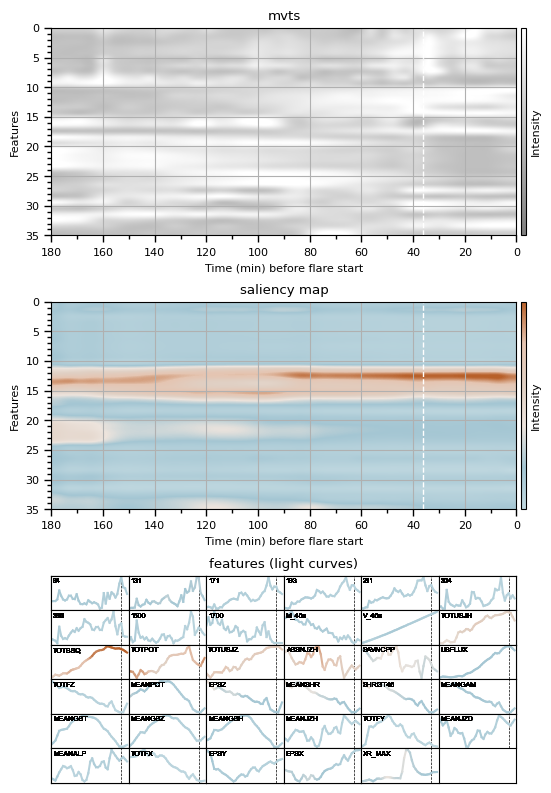

In [73]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, labels = next(iter(dataloader))

# Select an example

name = 'plot_grad_cam'
example_indx = 2
mvts, y = data[example_indx], labels[example_indx]
mvts = mvts.unsqueeze_(0)
mvts = mvts.unsqueeze_(1)
mvts = mvts.requires_grad_()
mvts = torch.nan_to_num(mvts)

# Itterate over all models from each 50 folds 
attribution_masks = []
for model_indx in range(50):
    if model_indx in [27,37]: continue
    # Load best model for a specific fold
    model = CNNModel()
    model.load_state_dict(torch.load(f'../../models/cnn_std/{model_indx}.pth', map_location=torch.device('cpu')))
    model.eval();
    # Create a GuidedGradCam object based on the model and the desired layer
    guided_grad_cam = GuidedGradCam(model, model.conv3)
    # Compute the attribution mask for the desired class
    attribution_mask = guided_grad_cam.attribute(mvts, target=y)
    attribution_mask = attribution_mask.squeeze().detach().numpy()
    # attribution_mask = attribution_mask / np.nanmax(attribution_mask)
    attribution_mask = unity_based_normalization(attribution_mask)
    attribution_masks.append(attribution_mask)
    # delete model
    del model

# Plot the attribution mask

mvts = mvts.squeeze().detach().numpy()
attribution_masks = np.array(attribution_masks)
attribution_mask = np.nanmean(attribution_masks, axis=0)
# Find max value in attribution mask as a mean along the features
max_val = np.nanmax(attribution_mask, axis=1)
max_val_t_loc = np.nanargmax(max_val)

plot_attributions(mvts, attribution_mask,max_val=max_val_t_loc, name=name)

In [69]:
files_in_sub

['aia.lev1_euv_12s.2015-09-29T152400Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T153000Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T153600Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T154200Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T154800Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T155400Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T160000Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T160600Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T161200Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T161800Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T162400Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T163000Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T163600Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T164200Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T164800Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T165400Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T170000Z.171.image.fits',
 'aia.lev1_euv_12s.2015-09-29T170600Z.171.image.fits',
 'aia.lev1

In [41]:
# collect paths and files corresponding to 36 

import os

fits_paths = []
root_path_to_fits = '../../data/M_897/'
for subdir in os.listdir(root_path_to_fits):
    if subdir == 'ndarrays' or subdir == '.DS_Store' or subdir == 'vids': continue
    files_in_sub = sorted(os.listdir(root_path_to_fits + subdir))
    fits_paths.append(root_path_to_fits + subdir + '/' + files_in_sub[35])
fits_paths

['../../data/M_897/1600/aia.lev1_uv_24s.2015-09-29T185348Z.1600.image.fits',
 '../../data/M_897/mag/hmi.m_45s.20150929_185445_TAI.2.magnetogram.fits',
 '../../data/M_897/94/aia.lev1_euv_12s.2015-09-29T185400Z.94.image.fits',
 '../../data/M_897/193/aia.lev1_euv_12s.2015-09-29T185400Z.193.image.fits',
 '../../data/M_897/211/aia.lev1_euv_12s.2015-09-29T185400Z.211.image.fits',
 '../../data/M_897/131/aia.lev1_euv_12s.2015-09-29T185400Z.131.image.fits',
 '../../data/M_897/304/aia.lev1_euv_12s.2015-09-29T185400Z.304.image.fits',
 '../../data/M_897/vel/hmi.v_45s.20150929_185445_TAI.2.Dopplergram.fits',
 '../../data/M_897/335/aia.lev1_euv_12s.2015-09-29T185400Z.335.image.fits',
 '../../data/M_897/1700/aia.lev1_uv_24s.2015-09-29T191748Z.1700.image.fits',
 '../../data/M_897/171/aia.lev1_euv_12s.2015-09-29T185400Z.171.image.fits']

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # for placing colorbar

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u

import sunpy.map
import sunpy.data.sample  # This line is only necessary if you want to use sample data
from sunpy.visualization.colormaps import color_tables as ct

plt.rcParams['font.size'] = 5  # This sets the font size to 10 pts, adjust as needed

In [74]:
def plot_fits_images(fits_paths, save_name=None):
    '''
    fits_paths is a list of paths to fits files
    Plots a grid of images from the fits files
    '''
    
    fig = plt.figure(figsize=(15, 12))
    axs = []

    for idx, fits_path in enumerate(fits_paths):
        with fits.open(fits_path) as hdul:
            header = hdul[1].header
            data = hdul[1].data

        wcs_sliced = WCS(header, naxis=[1, 2])

        if idx < len(axs):
            ax = axs[idx]
        else:
            ax = fig.add_subplot(3, 4, idx+1, projection=wcs_sliced)
            axs.append(ax)

        obs_date_time = header.get('DATE-OBS', "Unknown Date")
        vmin_val, vmax_val = np.percentile(data, [1, 99])

        if 'aia' in fits_path:
            # data = data * header['DN_GAIN'] 
            vmin_val, vmax_val = np.percentile(data, [1, 99])
            aia_map = sunpy.map.Map(data, header)
            channel = int(aia_map.meta['wavelnth'])
            channel_wavelength = channel * u.angstrom
            cmap = ct.aia_color_table(channel_wavelength)
            title = f'AIA {channel} Date-Time: {obs_date_time}'
            c_bar_label = 'Intensity [DN/s]'
        elif 'magnetogram' in fits_path:
            cmap = 'binary_r'
            title = f'Magnetogram Date-Time: {obs_date_time}'
            c_bar_label = 'Magnetic Field Strength [Gauss]'
        elif 'Dopplergram' in fits_path:
            cmap = 'coolwarm'
            title = f'Dopplergram Date-Time: {obs_date_time}'
            data = data - np.mean(data)
            vmin_val, vmax_val = np.percentile(data, [1, 99])
            c_bar_label = 'Velocity [m/s]'

        ax.imshow(data, origin='lower', cmap=cmap, vmin=vmin_val, vmax=vmax_val, alpha=0.7)
        ax.set_title(title)
        ax.coords.grid(True, color='white', ls='--')
        ax.coords[0].set_axislabel('Solar X [arcsec]')
        ax.coords[1].set_axislabel('Solar Y [arcsec]')

        # Using inset_axes to create space for the colorbar within the ax
        cbar_ax = inset_axes(ax, width='3%', height='100%', loc='lower left',
                             bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        cbar = plt.colorbar(ax.images[0], cax=cbar_ax, orientation='vertical')
        cbar.set_label(c_bar_label)

    plt.subplots_adjust(hspace=-0.7, wspace=0.5)  # adjust these values as needed
    if save_name is not None:
        plt.savefig('/Users/brandonlpanos/papers/transformer/{save_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return None

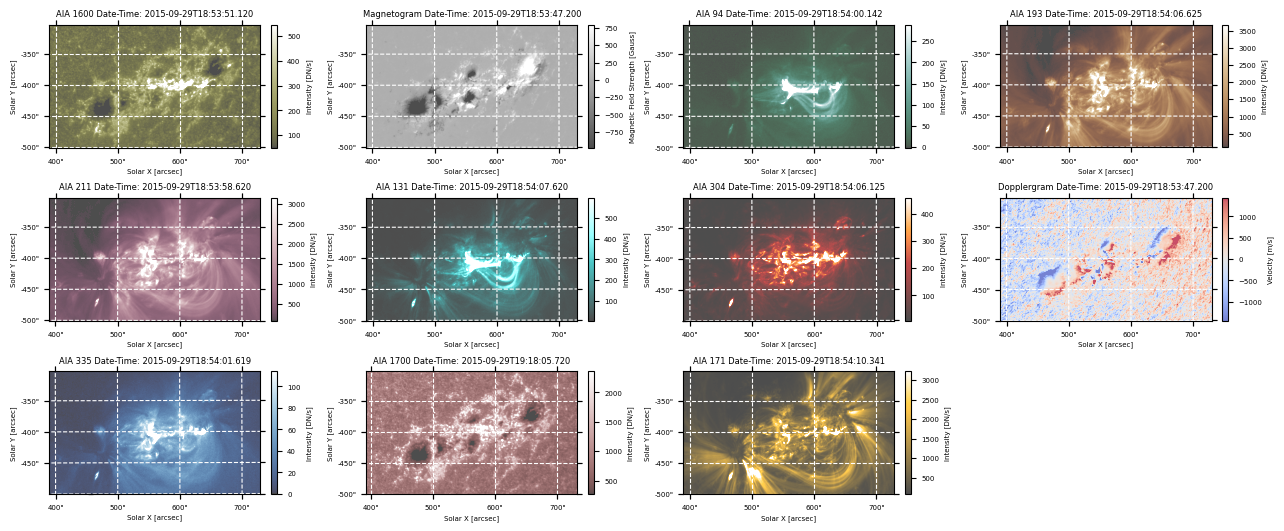

In [64]:
# Example usage:
plot_fits_images(fits_paths, save_name='aia_hmi_collage_high_prob')

**Low score** also calculate the prediction 

In [75]:
fits_paths = []
root_path_to_fits = '../../data/M_897/'
for subdir in os.listdir(root_path_to_fits):
    if subdir == 'ndarrays' or subdir == '.DS_Store' or subdir == 'vids': continue
    files_in_sub = sorted(os.listdir(root_path_to_fits + subdir))
    fits_paths.append(root_path_to_fits + subdir + '/' + files_in_sub[0])
fits_paths

['../../data/M_897/1600/aia.lev1_uv_24s.2015-09-29T152348Z.1600.image.fits',
 '../../data/M_897/mag/hmi.m_45s.20150929_152445_TAI.2.magnetogram.fits',
 '../../data/M_897/94/aia.lev1_euv_12s.2015-09-29T152400Z.94.image.fits',
 '../../data/M_897/193/aia.lev1_euv_12s.2015-09-29T152400Z.193.image.fits',
 '../../data/M_897/211/aia.lev1_euv_12s.2015-09-29T152400Z.211.image.fits',
 '../../data/M_897/131/aia.lev1_euv_12s.2015-09-29T152400Z.131.image.fits',
 '../../data/M_897/304/aia.lev1_euv_12s.2015-09-29T152400Z.304.image.fits',
 '../../data/M_897/vel/hmi.v_45s.20150929_152445_TAI.2.Dopplergram.fits',
 '../../data/M_897/335/aia.lev1_euv_12s.2015-09-29T152400Z.335.image.fits',
 '../../data/M_897/1700/aia.lev1_uv_24s.2015-09-29T152348Z.1700.image.fits',
 '../../data/M_897/171/aia.lev1_euv_12s.2015-09-29T152400Z.171.image.fits']

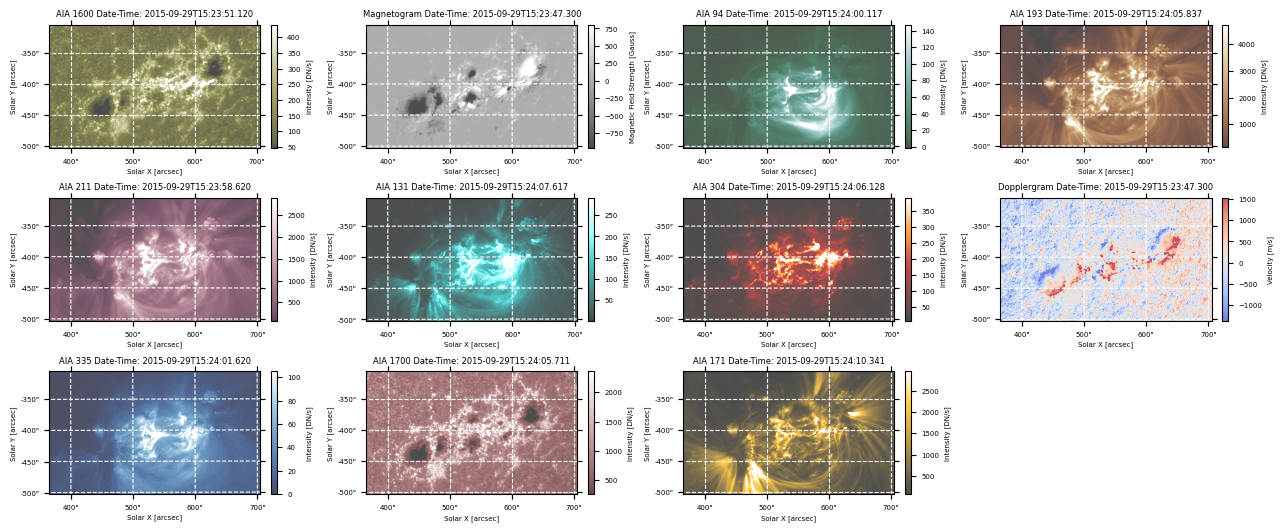

In [79]:
# Example usage:
plot_fits_images(fits_paths, save_name=None)

In [ ]:
# Should keep the same color vmax vmin or change obsevation to low 